# Pre-processing

In [81]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [82]:
data = pd.read_csv('data/spotify_songs.csv')

In [83]:
display(data)
display(data.describe().T.style.background_gradient(cmap='YlGnBu'))

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.102000,0.000000,0.0653,0.5180,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.072400,0.004210,0.3570,0.6930,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.079400,0.000023,0.1100,0.6130,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.028700,0.000009,0.2040,0.2770,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.080300,0.000000,0.0833,0.7250,123.976,189052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32828,7bxnKAamR3snQ1VGLuVfC1,City Of Lights - Official Radio Edit,Lush & Simon,42,2azRoBBWEEEYhqV6sb7JrT,City Of Lights (Vocal Mix),2014-04-28,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,...,2,-1.814,1,0.0936,0.076600,0.000000,0.0668,0.2100,128.170,204375
32829,5Aevni09Em4575077nkWHz,Closer - Sultan & Ned Shepard Remix,Tegan and Sara,20,6kD6KLxj7s8eCE3ABvAyf5,Closer Remixed,2013-03-08,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,...,0,-4.462,1,0.0420,0.001710,0.004270,0.3750,0.4000,128.041,353120
32830,7ImMqPP3Q1yfUHvsdn7wEo,Sweet Surrender - Radio Edit,Starkillers,14,0ltWNSY9JgxoIZO4VzuCa6,Sweet Surrender (Radio Edit),2014-04-21,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,...,6,-4.899,0,0.0481,0.108000,0.000001,0.1500,0.4360,127.989,210112
32831,2m69mhnfQ1Oq6lGtXuYhgX,Only For You - Maor Levi Remix,Mat Zo,15,1fGrOkHnHJcStl14zNx8Jy,Only For You (Remixes),2014-01-01,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,...,2,-3.361,1,0.1090,0.007920,0.127000,0.3430,0.3080,128.008,367432


,count,mean,std,min,25%,50%,75%,max
track_popularity,32833.000000,42.477081,24.984074,0.000000,24.000000,45.000000,62.000000,100.000000
danceability,32833.000000,0.654850,0.145085,0.000000,0.563000,0.672000,0.761000,0.983000
energy,32833.000000,0.698619,0.180910,0.000175,0.581000,0.721000,0.840000,1.000000
key,32833.000000,5.374471,3.611657,0.000000,2.000000,6.000000,9.000000,11.000000
loudness,32833.000000,-6.719499,2.988436,-46.448000,-8.171000,-6.166000,-4.645000,1.275000
mode,32833.000000,0.565711,0.495671,0.000000,0.000000,1.000000,1.000000,1.000000
speechiness,32833.000000,0.107068,0.101314,0.000000,0.041000,0.062500,0.132000,0.918000
acousticness,32833.000000,0.175334,0.219633,0.000000,0.015100,0.080400,0.255000,0.994000
instrumentalness,32833.000000,0.084747,0.224230,0.000000,0.000000,0.000016,0.004830,0.994000
liveness,32833.000000,0.190176,0.154317,0.000000,0.092700,0.127000,0.248000,0.996000


In [84]:
# check for missing values
missing_values = data.isnull().sum()
display(missing_values)

# display the lines with missing values
missing_data = data[data.isnull().any(axis=1)]
display(missing_data)

track_id                    0
track_name                  5
track_artist                5
track_popularity            0
track_album_id              0
track_album_name            5
track_album_release_date    0
playlist_name               0
playlist_id                 0
playlist_genre              0
playlist_subgenre           0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
duration_ms                 0
dtype: int64

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
8151,69gRFGOWY9OMpFJgFol1u0,NaN,NaN,0,717UG2du6utFe7CdmpuUe3,NaN,2012-01-05,HIP&HOP,5DyJsJZOpMJh34WvUrQzMV,rap,...,6,-7.635,1,0.1760,0.0410,0.00000,0.1160,0.649,95.999,282707
9282,5cjecvX0CmC9gK0Laf5EMQ,NaN,NaN,0,3luHJEPw434tvNbme3SP8M,NaN,2017-12-01,GANGSTA Rap,5GA8GDo7RQC3JEanT81B3g,rap,...,11,-5.364,0,0.3190,0.0534,0.00000,0.5530,0.191,146.153,202235
9283,5TTzhRSWQS4Yu8xTgAuq6D,NaN,NaN,0,3luHJEPw434tvNbme3SP8M,NaN,2017-12-01,GANGSTA Rap,5GA8GDo7RQC3JEanT81B3g,rap,...,10,-5.907,0,0.3070,0.0963,0.00000,0.0888,0.505,86.839,206465
19568,3VKFip3OdAvv4OfNTgFWeQ,NaN,NaN,0,717UG2du6utFe7CdmpuUe3,NaN,2012-01-05,Reggaeton viejito🔥,0si5tw70PIgPkY1Eva6V8f,latin,...,11,-6.075,0,0.0366,0.0606,0.00653,0.1030,0.726,97.017,252773
19811,69gRFGOWY9OMpFJgFol1u0,NaN,NaN,0,717UG2du6utFe7CdmpuUe3,NaN,2012-01-05,latin hip hop,3nH8aytdqNeRbcRCg3dw9q,latin,...,6,-7.635,1,0.1760,0.0410,0.00000,0.1160,0.649,95.999,282707


In [85]:
# Remove id columns
data = data.drop(columns=['track_id', 'track_album_id', "playlist_id"], axis=1)
# drop the missing values
data = data.dropna()
display(data)


,track_name,track_artist,track_popularity,track_album_name,track_album_release_date,playlist_name,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,pop,dance pop,0.748,0.916,6,-2.634,1,0.0583,0.102000,0.000000,0.0653,0.5180,122.036,194754
1,Memories - Dillon Francis Remix,Maroon 5,67,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,pop,dance pop,0.726,0.815,11,-4.969,1,0.0373,0.072400,0.004210,0.3570,0.6930,99.972,162600
2,All the Time - Don Diablo Remix,Zara Larsson,70,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,pop,dance pop,0.675,0.931,1,-3.432,0,0.0742,0.079400,0.000023,0.1100,0.6130,124.008,176616
3,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,Call You Mine - The Remixes,2019-07-19,Pop Remix,pop,dance pop,0.718,0.930,7,-3.778,1,0.1020,0.028700,0.000009,0.2040,0.2770,121.956,169093
4,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,pop,dance pop,0.650,0.833,1,-4.672,1,0.0359,0.080300,0.000000,0.0833,0.7250,123.976,189052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32828,City Of Lights - Official Radio Edit,Lush & Simon,42,City Of Lights (Vocal Mix),2014-04-28,♥ EDM LOVE 2020,edm,progressive electro house,0.428,0.922,2,-1.814,1,0.0936,0.076600,0.000000,0.0668,0.2100,128.170,204375
32829,Closer - Sultan & Ned Shepard Remix,Tegan and Sara,20,Closer Remixed,2013-03-08,♥ EDM LOVE 2020,edm,progressive electro house,0.522,0.786,0,-4.462,1,0.0420,0.001710,0.004270,0.3750,0.4000,128.041,353120
32830,Sweet Surrender - Radio Edit,Starkillers,14,Sweet Surrender (Radio Edit),2014-04-21,♥ EDM LOVE 2020,edm,progressive electro house,0.529,0.821,6,-4.899,0,0.0481,0.108000,0.000001,0.1500,0.4360,127.989,210112
32831,Only For You - Maor Levi Remix,Mat Zo,15,Only For You (Remixes),2014-01-01,♥ EDM LOVE 2020,edm,progressive electro house,0.626,0.888,2,-3.361,1,0.1090,0.007920,0.127000,0.3430,0.3080,128.008,367432


In [86]:
# transform track_album_release_date into datetime
data['track_album_release_date'] = pd.to_datetime(data['track_album_release_date'], format='mixed')

# transform categorical columns into categorical data type
categorical_cols = ['playlist_genre', 'playlist_subgenre', 'track_artist', 'playlist_name', 'track_album_name']
for col in categorical_cols:
    data[col] = data[col].astype('category')

# transform the duration_ms into minutes
data['duration_s'] = data['duration_ms'] / 1000
data.drop(columns=['duration_ms'], inplace=True)

# For numeric columns that represent discrete values (like key and mode), convert to categorical
key_mapping = {
    0: 'C', 1: 'C♯/D♭', 2: 'D', 3: 'D♯/E♭', 4: 'E', 5: 'F',
    6: 'F♯/G♭', 7: 'G', 8: 'G♯/A♭', 9: 'A', 10: 'A♯/B♭', 11: 'B'
}
data['key'] = data['key'].map(key_mapping).astype('category')

data['mode'] = data['mode'].map({0: 'Minor', 1: 'Major'}).astype('category')



In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32828 entries, 0 to 32832
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   track_name                32828 non-null  object        
 1   track_artist              32828 non-null  category      
 2   track_popularity          32828 non-null  int64         
 3   track_album_name          32828 non-null  category      
 4   track_album_release_date  32828 non-null  datetime64[ns]
 5   playlist_name             32828 non-null  category      
 6   playlist_genre            32828 non-null  category      
 7   playlist_subgenre         32828 non-null  category      
 8   danceability              32828 non-null  float64       
 9   energy                    32828 non-null  float64       
 10  key                       32828 non-null  category      
 11  loudness                  32828 non-null  float64       
 12  mode                   

In [88]:
data

,track_name,track_artist,track_popularity,track_album_name,track_album_release_date,playlist_name,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_s
0,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,pop,dance pop,0.748,0.916,F♯/G♭,-2.634,Major,0.0583,0.102000,0.000000,0.0653,0.5180,122.036,194.754
1,Memories - Dillon Francis Remix,Maroon 5,67,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,pop,dance pop,0.726,0.815,B,-4.969,Major,0.0373,0.072400,0.004210,0.3570,0.6930,99.972,162.600
2,All the Time - Don Diablo Remix,Zara Larsson,70,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,pop,dance pop,0.675,0.931,C♯/D♭,-3.432,Minor,0.0742,0.079400,0.000023,0.1100,0.6130,124.008,176.616
3,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,Call You Mine - The Remixes,2019-07-19,Pop Remix,pop,dance pop,0.718,0.930,G,-3.778,Major,0.1020,0.028700,0.000009,0.2040,0.2770,121.956,169.093
4,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,pop,dance pop,0.650,0.833,C♯/D♭,-4.672,Major,0.0359,0.080300,0.000000,0.0833,0.7250,123.976,189.052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32828,City Of Lights - Official Radio Edit,Lush & Simon,42,City Of Lights (Vocal Mix),2014-04-28,♥ EDM LOVE 2020,edm,progressive electro house,0.428,0.922,D,-1.814,Major,0.0936,0.076600,0.000000,0.0668,0.2100,128.170,204.375
32829,Closer - Sultan & Ned Shepard Remix,Tegan and Sara,20,Closer Remixed,2013-03-08,♥ EDM LOVE 2020,edm,progressive electro house,0.522,0.786,C,-4.462,Major,0.0420,0.001710,0.004270,0.3750,0.4000,128.041,353.120
32830,Sweet Surrender - Radio Edit,Starkillers,14,Sweet Surrender (Radio Edit),2014-04-21,♥ EDM LOVE 2020,edm,progressive electro house,0.529,0.821,F♯/G♭,-4.899,Minor,0.0481,0.108000,0.000001,0.1500,0.4360,127.989,210.112
32831,Only For You - Maor Levi Remix,Mat Zo,15,Only For You (Remixes),2014-01-01,♥ EDM LOVE 2020,edm,progressive electro house,0.626,0.888,D,-3.361,Major,0.1090,0.007920,0.127000,0.3430,0.3080,128.008,367.432


In [89]:
num = data.select_dtypes(include='number')
cat = data.select_dtypes(include='category')
print('Data quantitative :', round(100*num.shape[1]/data.shape[1], 2), '%')
print('Data qualitative :', round(100*cat.shape[1]/data.shape[1], 2), '%')

Data quantitative : 55.0 %
Data qualitative : 35.0 %


In [101]:
# copier data dans data_songs
data_songs = data.copy()

# observer les données dupliquées sur toutes les colonnes
duplicates = data_songs.duplicated().sum()
print(f'Number of duplicates: {duplicates}')

# Nombre de valeurs dupliquées avant suppression
initial_duplicates = data_songs.duplicated(subset=['track_artist', 'track_name']).sum()
print(f'Initial number of duplicates: {initial_duplicates}')

# Supprimer les colonnes 'playlist'
data_songs = data_songs.drop(columns=['playlist_genre', 'playlist_subgenre', 'playlist_name'])

# Regarder le nombre de doublons après suppression
duplicates = data_songs.duplicated().sum()
print(f'Number of duplicates: {duplicates}')

# Supprimer les doublons
data_songs = data_songs.drop_duplicates()

# regarder le nombre de doublons en fonction de 'track_artist' et 'track_name'
duplicates = data_songs.duplicated(subset=['track_artist', 'track_name']).sum()
print(f'Number of duplicates: {duplicates}')

# garder dans data_songs les lignes dupliquées ayant la popularité la plus élevée
data_songs = data_songs.sort_values('track_popularity', ascending=False).drop_duplicates(subset=['track_artist', 'track_name'])
# regarder le nombre de doublons en fonction de 'track_artist' et 'track_name'
duplicates = data_songs.duplicated().sum()
print(f'Number of duplicates: {duplicates}')



Number of duplicates: 0
Initial number of duplicates: 6599
Number of duplicates: 4482
Number of duplicates: 2117
Number of duplicates: 0


In [103]:
# vérifier le nombre de lignes dans data_songs
print(f'Number of rows in data_songs: {data_songs.shape[0]}')

# Afficher le nom des colonnes dans data_songs
print(data_songs.columns)

Number of rows in data_songs: 26229
Index(['track_name', 'track_artist', 'track_popularity', 'track_album_name',
       'track_album_release_date', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_s'],
      dtype='object')


<style>
    .analyse {
    color:rgba(77, 146, 241, 0.94);
    font-weight: bold;
    font-size: 18px;
}
    .red-text {
    color:rgb(255, 0, 0);
    font-weight: bold;
    font-size: 18px;
}
</style>

<div class="analyse">Analyse des résultats</div>
<div class="red-text">ATTENTION : ici on a remarqué dans le dataset qu'on a des duplicata de musiques (track_id et aussi des fois on a des musiques qui sont sortis en EP et dans des albums) </div>

**Observation :**  
* Dans un 1er temps on va étudier uniquement les musiques, indépendamment pour cela on a créé un nouveau dataset qui supprime tous les doublons (même nom de track et même artiste) en gardant la track qui a la popularité la plus élevée.
* Dans un second temps on étudiera en fonction des playlists la popularité des genres etc. 

**Notes :**
* Penser à enlever dans le notebook final les vérifications de compte


# Descriptive Analysis

## Analyse univariée

<style>
.commentaire {
    color:rgb(48, 140, 26);
    font-weight: bold;
    font-size: 18px;
}
</style>

<div class="commentaire">Fonction : plot_specific_variables</div>

**Description :**  
Création d'une fonction qui est plus modulable pour l'affichage des analyses univariées en fonction du type d'affichage que l'on souhaite.


In [104]:
def plot_specific_variables(data, variable_plot_map):
    """
    Génère des graphiques pour des variables spécifiques en fonction d'un mappage donné.

    :param data: DataFrame contenant les données.
    :param variable_plot_map: Dictionnaire où les clés sont les noms des variables et les valeurs sont les types de graphiques à générer.
    """
    # Créer une figure avec plusieurs sous-graphiques
    num_plots = len(variable_plot_map)
    fig, axes = plt.subplots(nrows=(num_plots + 1) // 2, ncols=2, figsize=(18, 6 * ((num_plots + 1) // 2)))
    axes = axes.flatten()

    plot_index = 0

    for var, plot_type in variable_plot_map.items():
        if plot_type == 'histogram':
            sns.histplot(data[var], kde=True, ax=axes[plot_index])
            axes[plot_index].set_title(f'Distribution of {var}')
            axes[plot_index].set_xlabel(var)
            axes[plot_index].set_ylabel('Frequency')
        elif plot_type == 'countplot':
            sns.countplot(y=var, data=data, order=data[var].value_counts().index, ax=axes[plot_index])
            axes[plot_index].set_title(f'Count of {var}')
            axes[plot_index].set_xlabel('Frequency')
            axes[plot_index].set_ylabel(var)
        elif plot_type == 'boxplot':
            sns.boxplot(x=data[var], ax=axes[plot_index])
            axes[plot_index].set_title(f'Boxplot of {var}')
            axes[plot_index].set_xlabel(var)
            axes[plot_index].set_ylabel('Frequency')
        elif plot_type == 'kde':
            sns.kdeplot(data[var], ax=axes[plot_index])
            axes[plot_index].set_title(f'KDE of {var}')
            axes[plot_index].set_xlabel(var)
            axes[plot_index].set_ylabel('Density')
        else:
            raise ValueError(f"Unknown plot type: {plot_type}")

        plot_index += 1

    # Masquer les sous-graphiques non utilisés
    for i in range(plot_index, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

<style>
    .analyse {
    color:rgba(77, 146, 241, 0.94);
    font-weight: bold;
    font-size: 18px;
}
</style>

<div class="analyse">Analyse des résultats</div>

**Observation :** 
- **Distrib de popularité :** 
- **Cpt du genre dans les playlist :**
- **Durée d'un morceau :**
- **KDE de danceability :**
- **Distrib de l'énergie :**

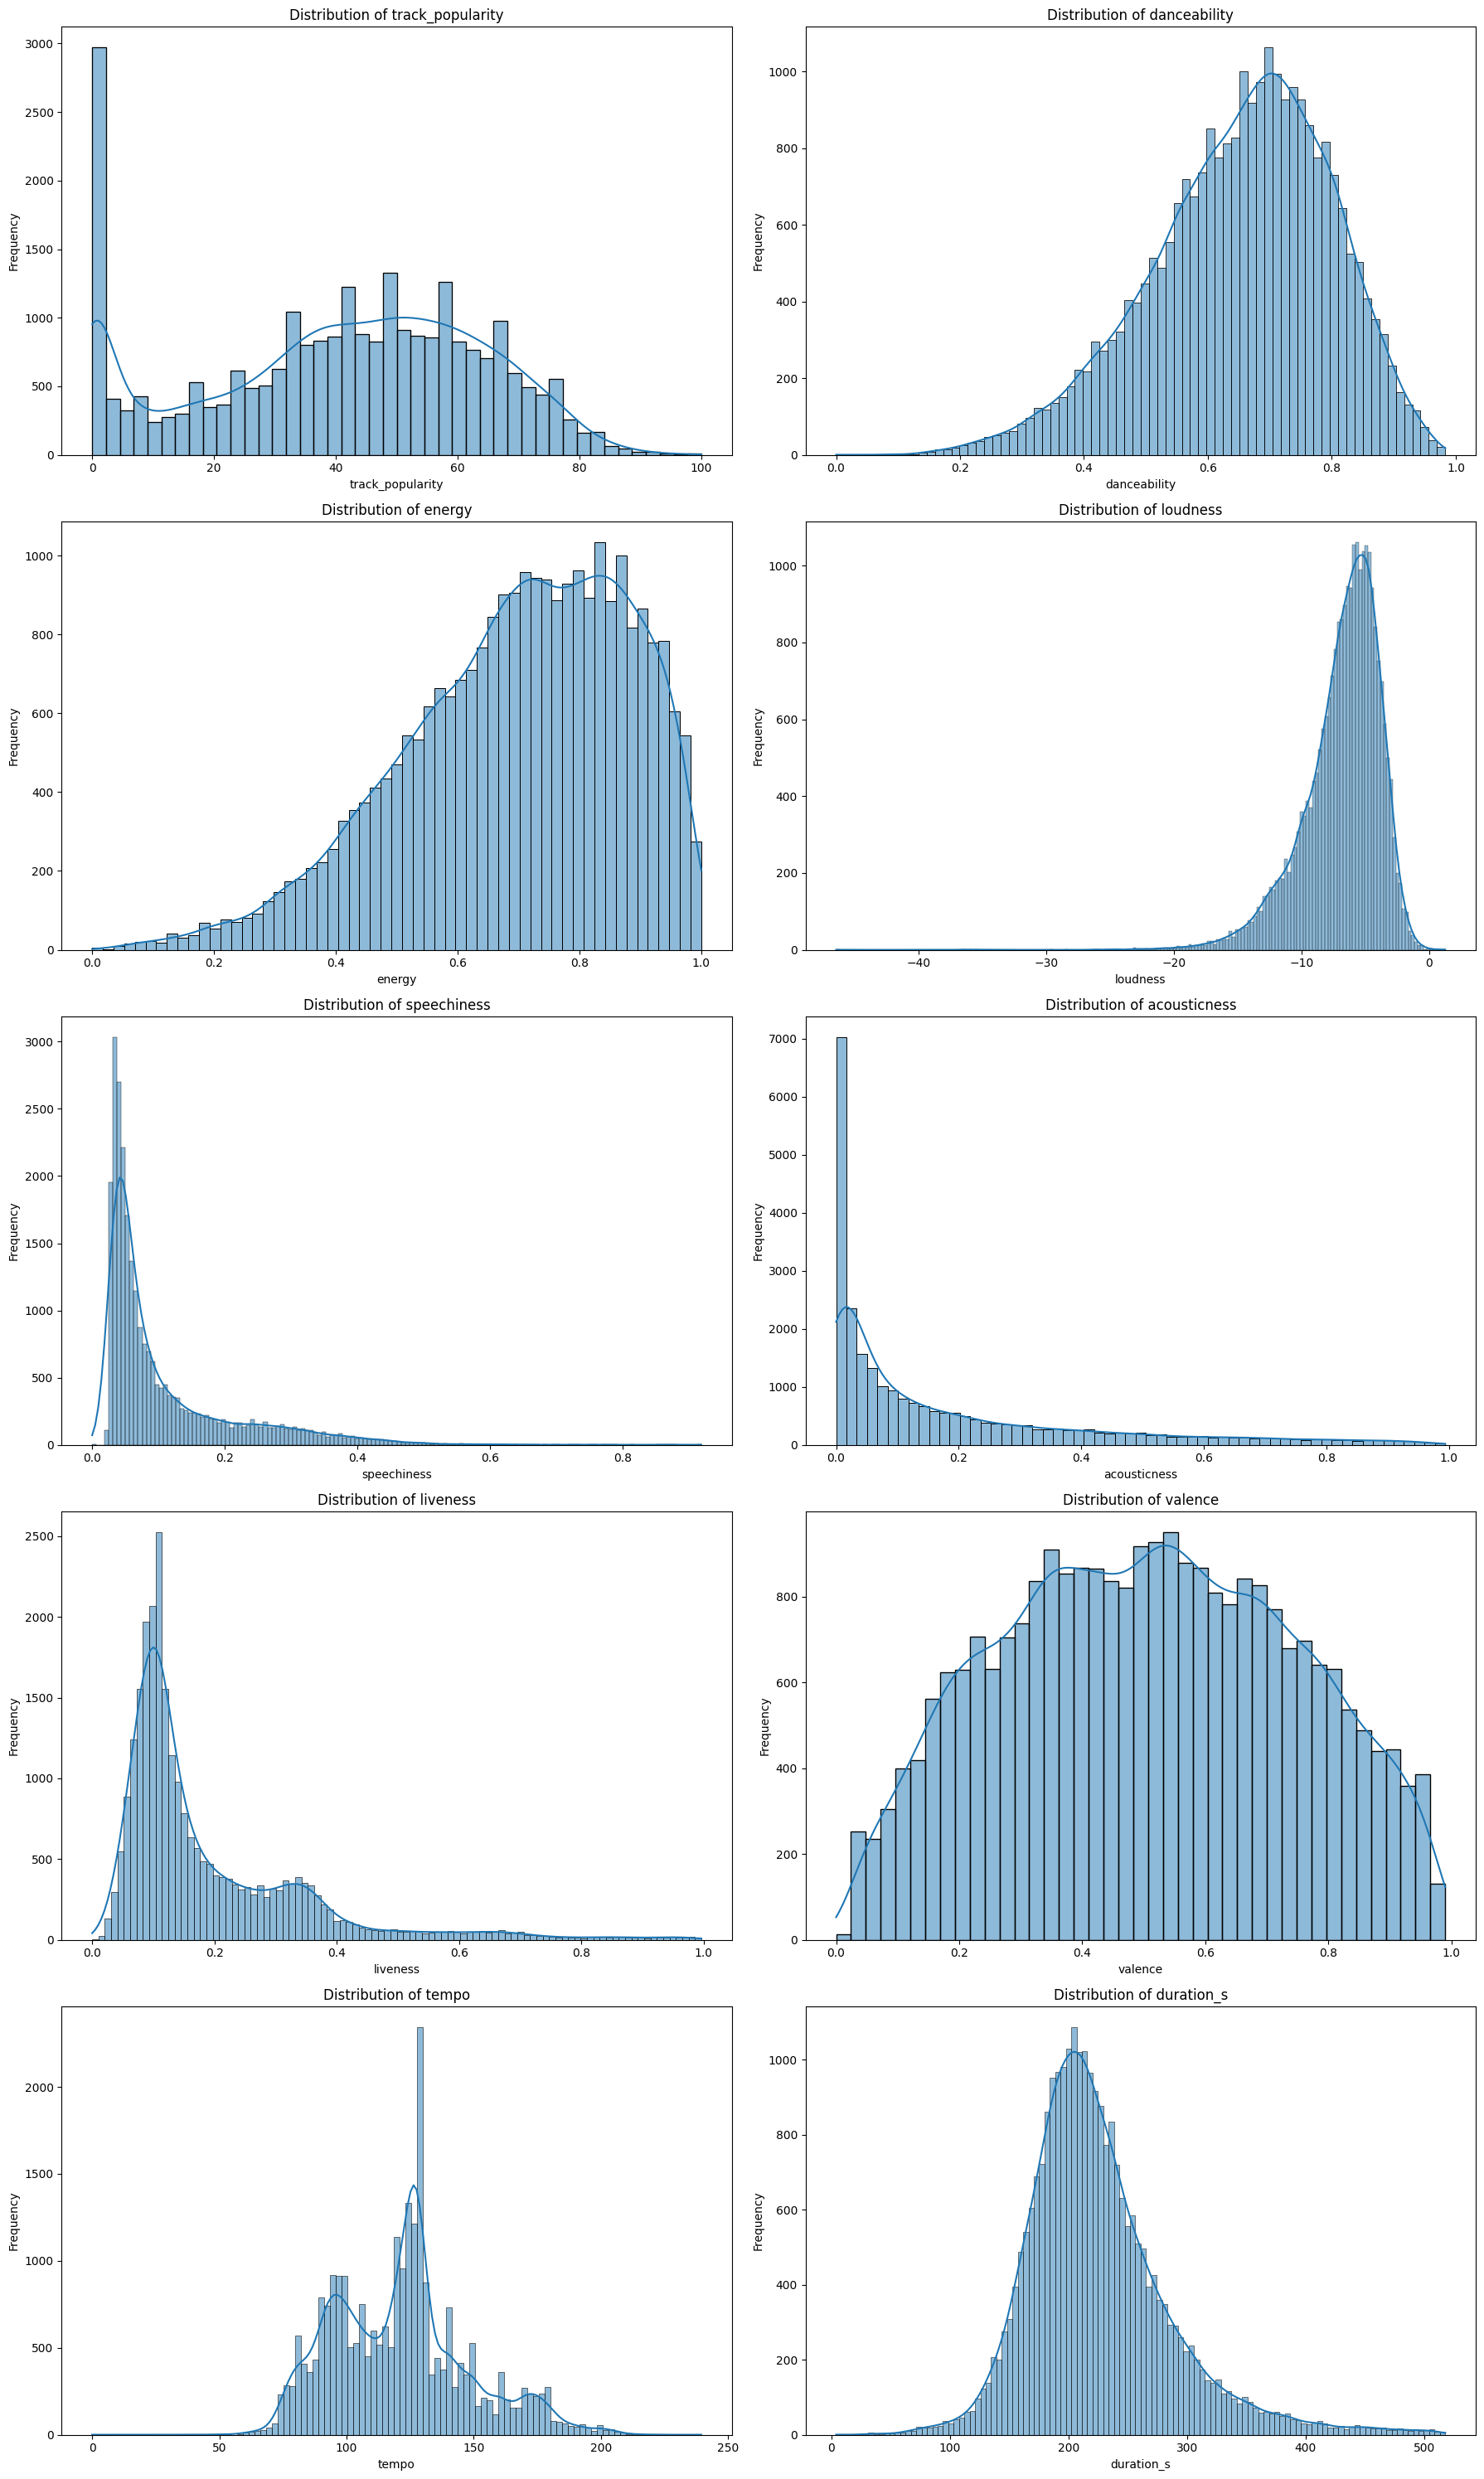

In [ ]:
# Mappage des variables aux types de graphiques
variable_plot_map = {
    'track_popularity': 'histogram',
    'danceability': 'histogram',
    'energy': 'histogram',
    'loudness': 'histogram',
    'speechiness': 'histogram',
    'acousticness': 'histogram',
    #'instrumentalness': 'histogram', # Revoir celui là
    'liveness': 'histogram',
    'valence': 'histogram',
    'tempo': 'histogram',
    'duration_s': 'histogram'
}

# Appel de la fonction plot_specific_variables avec le mappage sur data_songs
plot_specific_variables(data_songs, variable_plot_map) # type: ignore

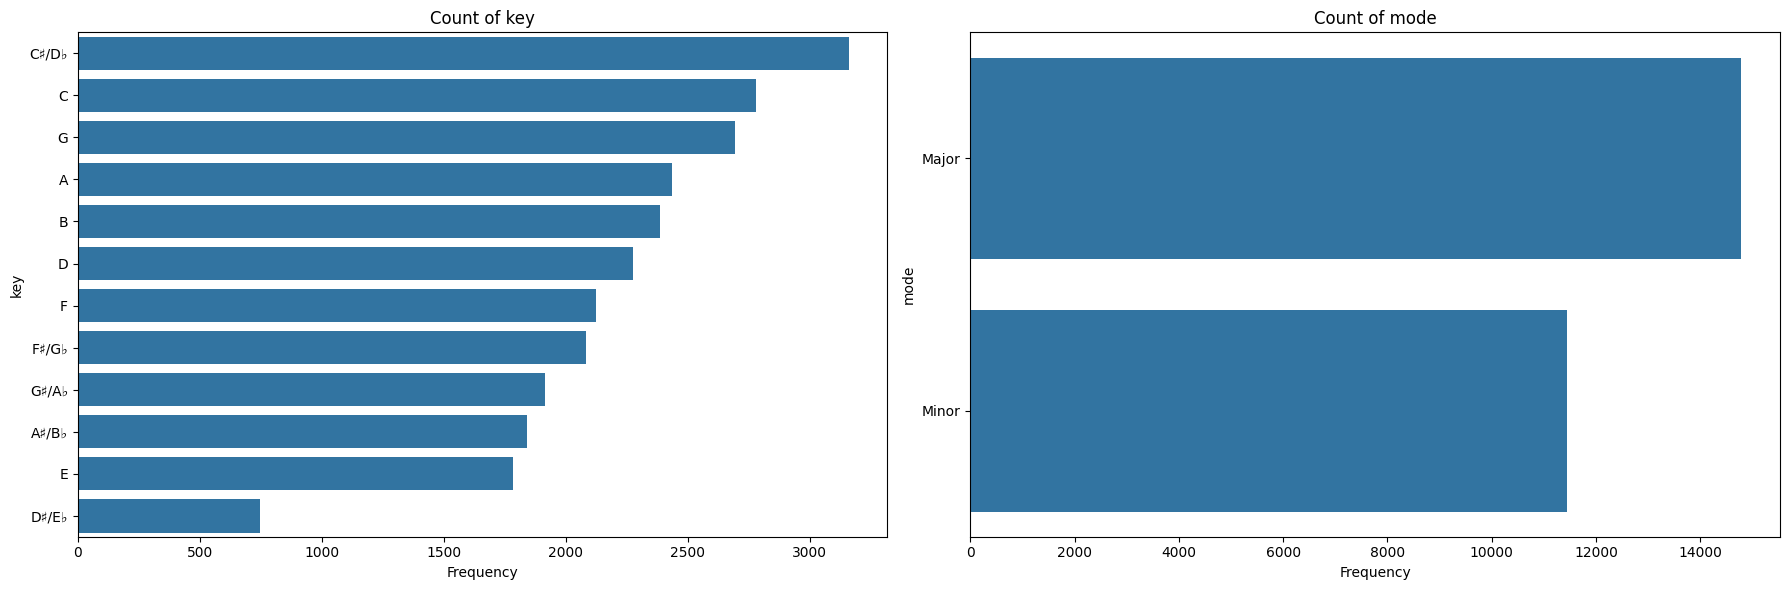

In [105]:
# Mappage des variables aux types de graphiques
variable_plot_map = {
    'key': 'countplot', # Attention il y a une erreur d'affichage pour les axes
    'mode': 'countplot' # Attention il y a une erreur d'affichage pour les axes
}


# Appel de la fonction avec le mappage
plot_specific_variables(data_songs, variable_plot_map) # type: ignore


<style>
    .analyse {
    color:rgba(77, 146, 241, 0.94);
    font-weight: bold;
    font-size: 18px;
}
</style>

<div class="analyse">Analyse des résultats</div>

**Observation :**  
- **Genre :** 
    - *EDM* est le genre qui apparait le plus.
    - *Rock* est celui qui apparait le moins.
    - Globalement tous les genres apparaissent entre 5000 et 6000 fois dans le dataset.

- **Sous-genre :**
    - Nous donne plus de détail sur les sous-genres apparaissant le plus.
    - Beaucoup plus varié sur le nb d'apparition du sous-genre => montre une grande diversité des styles musicaux.

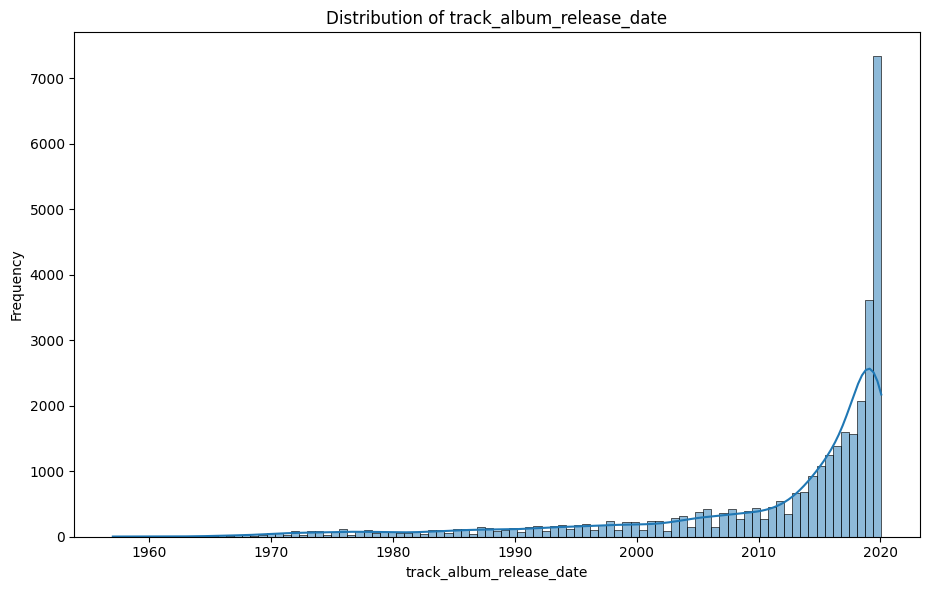

In [95]:
variable_plot_map = {
    'track_album_release_date': 'histogram'
}

# Appel de la fonction avec le mappage
plot_specific_variables(data, variable_plot_map)